In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Import Fasion MNIST, make it a TensorFlow Dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
example_x = x_test[:16]

batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# Define the encoding distribution, q(z|x)
latent_size=2
event_shape=(28,28)
encoder=Sequential([Flatten(input_shape=event_shape),Dense(256,activation='relu'),Dense(128,activation='relu')
                    ,Dense(64,activation='relu'),Dense(32,activation='relu'),Dense(2*latent_size)
                   ,tfpl.DistributionLambda( lambda t : tfd.MultivariateNormalDiag(loc=t[...,:latent_size]
                                                                                   ,scale_diag=tf.math.exp(t[...,latent_size:])))])

In [4]:
# Define the decoding distribution, p(x|z)

decoder=Sequential([Dense(32,activation='relu'),Dense(64,activation='relu')
                    ,Dense(128,activation='relu'),Dense(256,activation='relu'),Dense(tfpl.IndependentBernoulli.params_size(event_shape),
                                                                                    ),tfpl.IndependentBernoulli(event_shape)])

In [5]:
# Define the prior, p(z) - a standard bivariate Gaussian

prior=tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

In [6]:
# Specify the loss function, an estimate of the -ELBO

def loss(x, encoding_dist, sampled_decoding_dist, prior):
    return tf.reduce_sum(tfd.kl_divergence(encoding_dist,prior)-sampled_decoding_dist.log_prob(x))

In [7]:
# Define a function that returns the loss and its gradients

@tf.function

def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist=encoder(x)
        sampled_z=encoding_dist.sample() 
        sampled_decoding_dist=decoder(sampled_z)
        current_loss=loss(x, encoding_dist, sampled_decoding_dist, prior)
        
    grads=tape.gradient(current_loss,
        encoder.trainable_variables +
        decoder.trainable_variables)
    return current_loss, grads


In [8]:
# Compile and train the model

num_epochs = 30
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, encoder.trainable_variables
                                       + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy()))

-ELBO after epoch 1: 8898
-ELBO after epoch 2: 8771
-ELBO after epoch 3: 8789
-ELBO after epoch 4: 8737
-ELBO after epoch 5: 8807
-ELBO after epoch 6: 8712
-ELBO after epoch 7: 8694
-ELBO after epoch 8: 8671
-ELBO after epoch 9: 8692
-ELBO after epoch 10: 8919
-ELBO after epoch 11: 8682
-ELBO after epoch 12: 8636
-ELBO after epoch 13: 8702
-ELBO after epoch 14: 8669
-ELBO after epoch 15: 8695
-ELBO after epoch 16: 8601
-ELBO after epoch 17: 8619
-ELBO after epoch 18: 8731
-ELBO after epoch 19: 8705
-ELBO after epoch 20: 8615
-ELBO after epoch 21: 8851
-ELBO after epoch 22: 8575
-ELBO after epoch 23: 8593
-ELBO after epoch 24: 8555
-ELBO after epoch 25: 8616
-ELBO after epoch 26: 8611
-ELBO after epoch 27: 8570
-ELBO after epoch 28: 8574
-ELBO after epoch 29: 8831
-ELBO after epoch 30: 8837


In [9]:
# Connect encoder and decoder, compute a reconstruction
def vae(inputs):
    approx_posterior=encoder(inputs)
    decoding_dist=decoder(approx_posterior.sample())
    return decoding_dist.mean()
example_reconstruction=vae(example_x).numpy().squeeze()
    

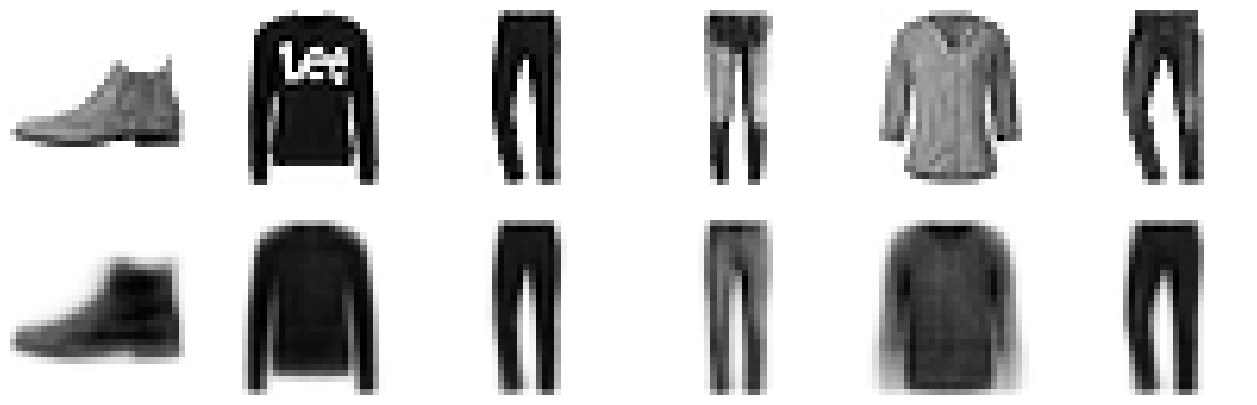

In [10]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')